### EXP: Full launch QC rating 

- **Aim:** Combine all results of full launch of quality control (QC) of brain registration on the Zooniverse platform. ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [16]:
# Read and merge ratings from superviser and non supervised experts with zooniverse consensus ratings
dfs = [pd.read_csv(xx) for xx in ['../data/rating/expert_project_2_ratings.csv',
                                  '../data/rating/full_launch_zooniverse_consensus.csv',
                                  '../data/rating/expert_project_1_ratings.csv'] ]
merge_ratings = reduce(lambda left,right: pd.merge(left,right,on='ID'), dfs)
merge_ratings.head()

,ID,Surc,Jpau,Cmak,Edup,Adoy,Zcon,Atam,Abad,Jche,Pfer,Czwe,Aher
0,X0026002,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe,Fail,Fail,Maybe,OK,OK,Fail
1,X0026016,Maybe,Maybe,Fail,Maybe,Maybe,Fail,OK,Maybe,Fail,OK,OK,Fail
2,X2740232,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail
3,X3917422,Maybe,Maybe,OK,Maybe,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Maybe,Fail
4,X0010007,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe,Fail,Maybe,OK,OK,Fail


###  Get Kappa score

In [17]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings = merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3})
df_ratings.head()

,ID,Surc,Jpau,Cmak,Edup,Adoy,Zcon,Atam,Abad,Jche,Pfer,Czwe,Aher
0,X0026002,2,2,2,2,2,2,3,3,2,1,1,3
1,X0026016,2,2,3,2,2,3,1,2,3,1,1,3
2,X2740232,3,3,3,3,3,3,3,3,3,3,3,3
3,X3917422,2,2,1,2,2,2,3,3,2,2,2,3
4,X0010007,2,2,2,2,2,2,2,3,2,1,1,3


In [18]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [19]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 12 
  %-agree = 17 



In [28]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [29]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [30]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.53 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 12 
    Kappa = 0.422 

        z = 48 
  p-value = 0 



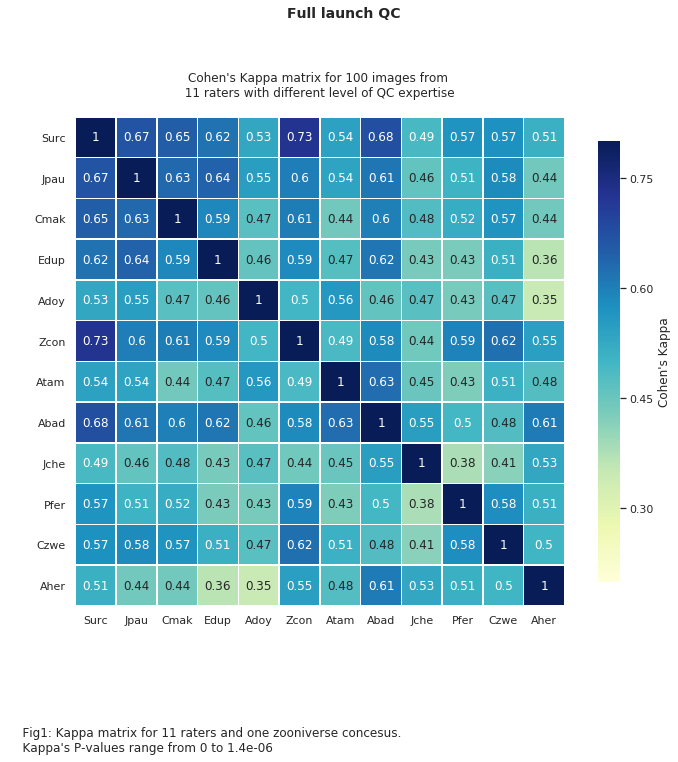

In [32]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (12,9))
f.subplots_adjust(hspace= .8)

f.suptitle('Full launch QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0.2,vmax=0.8,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  11 raters with different level of QC expertise  ".format(len(df_ratings)),
               pad=20,fontsize=12)
#axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
#              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
#                            fc="0.7", ec="none",
#                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 11 raters and one zooniverse concesus.
    Kappa's P-values range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Full-Launch-combined-kappa.svg')

In [33]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)